# 01 数据探索与诊断

## 第一阶段：全面数据诊断

本 Notebook 包含 9 大模块的分析，帮助我们了解数据特征、质量、并发现与收益相关的因子。

---

## 模块1: 数据质量诊断

**目标**：
- 检测缺失值和异常值
- 统计数据覆盖率
- 识别需要清洗的数据


In [88]:
# 导入依赖
import sys
import importlib
from pathlib import Path

# 添加项目根目录
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

try:
    from tqdm.notebook import tqdm as _notebook_tqdm
    if importlib.util.find_spec('ipywidgets') is not None:
        tqdm = _notebook_tqdm
    else:
        from tqdm import tqdm
except Exception:
    from tqdm import tqdm

from src.utils.config import load_config, get_data_path
from src.utils.io import load_parquet

# 配置中文显示
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

print(f"项目根目录: {project_root}")

项目根目录: g:\理财\Quant_A_share_LongTerm


### 1.1 数据完整性检查

In [89]:
# 定义数据路径
raw_path = get_data_path('raw')
meta_path = get_data_path('meta')

# 数据目录映射
data_dirs = {
    '股票基础信息': meta_path / 'stock_basic.parquet',
    '交易日历': meta_path / 'trade_cal.parquet',
    '日线行情': raw_path / 'market' / 'daily',
    '每日估值': raw_path / 'market' / 'daily_basic',
    '财务指标': raw_path / 'fundamental' / 'fina_indicator',
    '利润表': raw_path / 'fundamental' / 'income',
    '资产负债表': raw_path / 'fundamental' / 'balancesheet',
    '现金流量表': raw_path / 'fundamental' / 'cashflow',
}

# 统计各类数据
completeness = []

for name, path in data_dirs.items():
    if path.is_file():
        df = load_parquet(path)
        completeness.append({
            '数据类型': name,
            '文件/记录数': len(df),
            '状态': '✓ 正常'
        })
    elif path.is_dir():
        files = list(path.glob('*.parquet'))
        completeness.append({
            '数据类型': name,
            '文件/记录数': len(files),
            '状态': '✓ 正常' if len(files) >= 5000 else '⚠ 不完整'
        })
    else:
        completeness.append({
            '数据类型': name,
            '文件/记录数': 0,
            '状态': '✗ 缺失'
        })

df_completeness = pd.DataFrame(completeness)
print("=" * 50)
print("数据完整性检查")
print("=" * 50)
df_completeness

数据完整性检查


,数据类型,文件/记录数,状态
0,股票基础信息,5466,✓ 正常
1,交易日历,3883,✓ 正常
2,日线行情,5466,✓ 正常
3,每日估值,5466,✓ 正常
4,财务指标,5466,✓ 正常
5,利润表,5466,✓ 正常
6,资产负债表,5466,✓ 正常
7,现金流量表,5466,✓ 正常


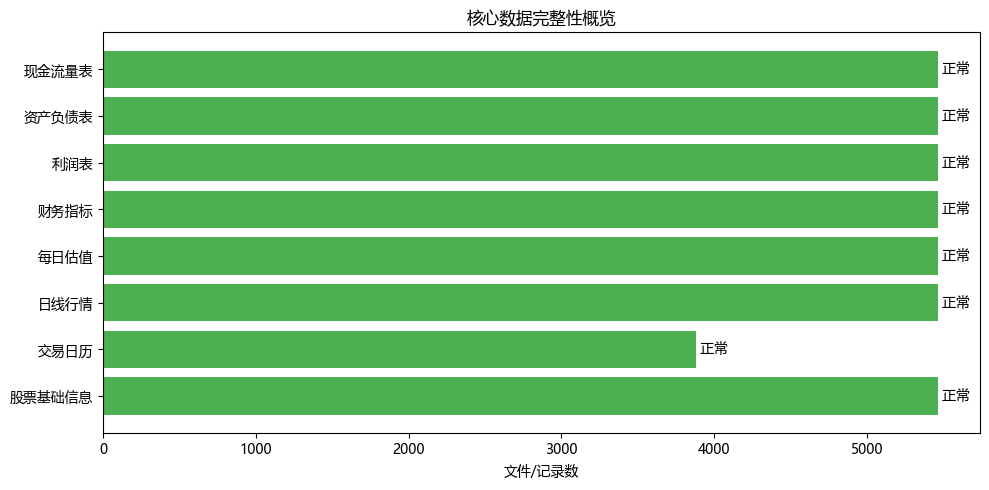

In [90]:
# 数据完整性可视化（移除特殊符号防止字体告警）
status_colors = {'正常': '#4caf50', '不完整': '#ff9800', '缺失': '#f44336'}
status_labels = {'✓ 正常': '正常', '⚠ 不完整': '不完整', '✗ 缺失': '缺失'}

df_plot = df_completeness.copy()
df_plot['状态简写'] = df_plot['状态'].map(status_labels).fillna('未知')

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(df_plot['数据类型'], df_plot['文件/记录数'],
                color=[status_colors.get(s, '#2196f3') for s in df_plot['状态简写']])

for rect, status in zip(bars, df_plot['状态简写']):
    ax.text(rect.get_width(), rect.get_y() + rect.get_height() / 2,
            f" {status}", va='center')

ax.set_xlabel('文件/记录数')
ax.set_title('核心数据完整性概览')
plt.tight_layout()
plt.show()

### 1.2 股票基础信息分析

In [91]:
# 加载股票基础信息
stock_basic = load_parquet(meta_path / 'stock_basic.parquet')

print(f"股票总数: {len(stock_basic)}")
print(f"\n字段列表: {list(stock_basic.columns)}")
print(f"\n空值统计:")
print(stock_basic.isnull().sum())

# 行业分布
print(f"\n行业数量: {stock_basic['industry'].nunique()}")

股票总数: 5466

字段列表: ['ts_code', 'symbol', 'name', 'area', 'industry', 'fullname', 'market', 'list_date', 'is_hs']

空值统计:
ts_code      0
symbol       0
name         0
area         2
industry     2
fullname     0
market       0
list_date    0
is_hs        1
dtype: int64

行业数量: 110


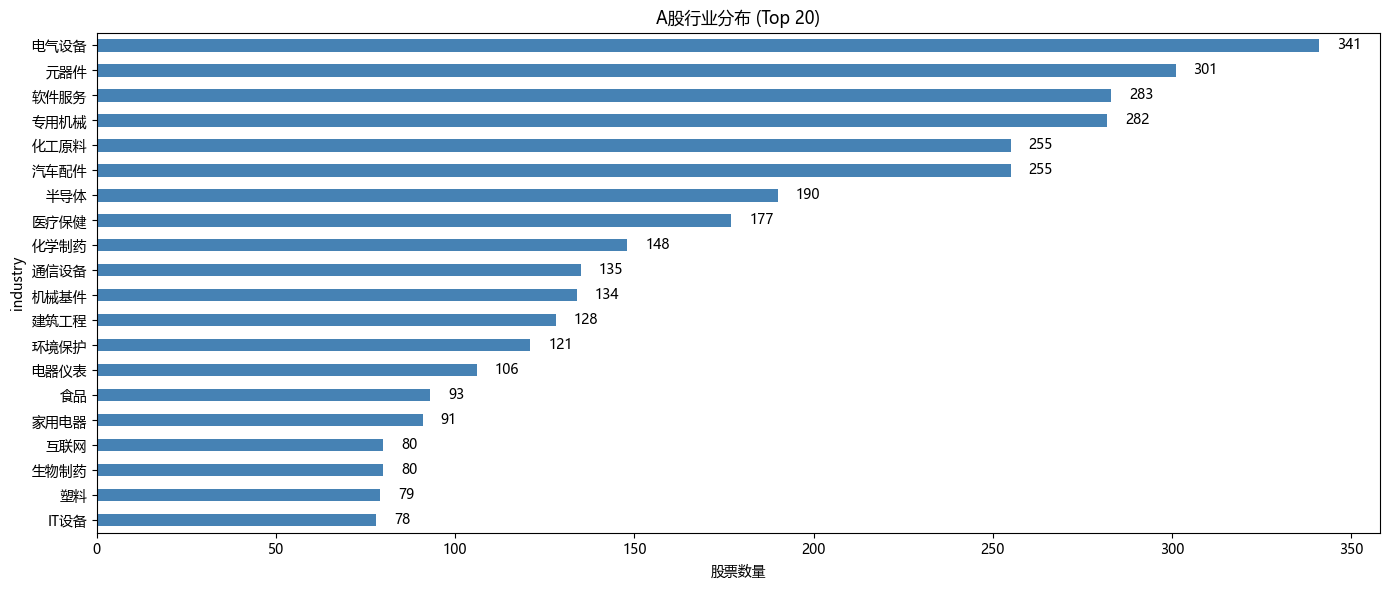

In [92]:
# 行业分布可视化
fig, ax = plt.subplots(figsize=(14, 6))

industry_counts = stock_basic['industry'].value_counts().head(20)
industry_counts.plot(kind='barh', ax=ax, color='steelblue')

ax.set_xlabel('股票数量')
ax.set_title('A股行业分布 (Top 20)')
ax.invert_yaxis()

for i, v in enumerate(industry_counts.values):
    ax.text(v + 5, i, str(v), va='center')

plt.tight_layout()
plt.show()

### 1.3 日线行情数据质量

In [93]:
# 采样检查日线数据
daily_dir = raw_path / 'market' / 'daily'
daily_files = list(daily_dir.glob('*.parquet'))[:1000]  # 采样1000个

daily_stats = []
for f in tqdm(daily_files, desc='检查日线数据'):
    df = load_parquet(f)
    if len(df) > 0:
        daily_stats.append({
            'ts_code': f.stem,
            '记录数': len(df),
            '开始日期': df['trade_date'].min(),
            '结束日期': df['trade_date'].max(),
            '空值比例': df.isnull().mean().mean() * 100
        })

df_daily_stats = pd.DataFrame(daily_stats)

print(f"采样股票数: {len(df_daily_stats)}")
print(f"平均记录数: {df_daily_stats['记录数'].mean():.0f}")
print(f"日期范围: {df_daily_stats['开始日期'].min()} 至 {df_daily_stats['结束日期'].max()}")
print(f"平均空值比例: {df_daily_stats['空值比例'].mean():.2f}%")

检查日线数据: 100%|██████████| 1000/1000 [00:05<00:00, 174.53it/s]

采样股票数: 1000
平均记录数: 3387
日期范围: 20100104 至 20251226
平均空值比例: 0.00%


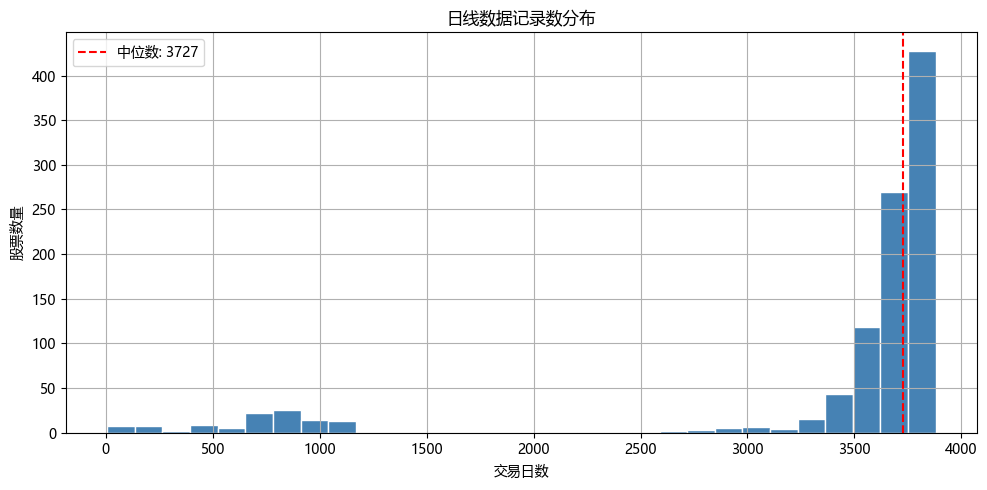

In [94]:
# 日线数据记录数分布
fig, ax = plt.subplots(figsize=(10, 5))

df_daily_stats['记录数'].hist(bins=30, ax=ax, color='steelblue', edgecolor='white')
ax.axvline(df_daily_stats['记录数'].median(), color='red', linestyle='--', label=f'中位数: {df_daily_stats["记录数"].median():.0f}')

ax.set_xlabel('交易日数')
ax.set_ylabel('股票数量')
ax.set_title('日线数据记录数分布')
ax.legend()

plt.tight_layout()
plt.show()

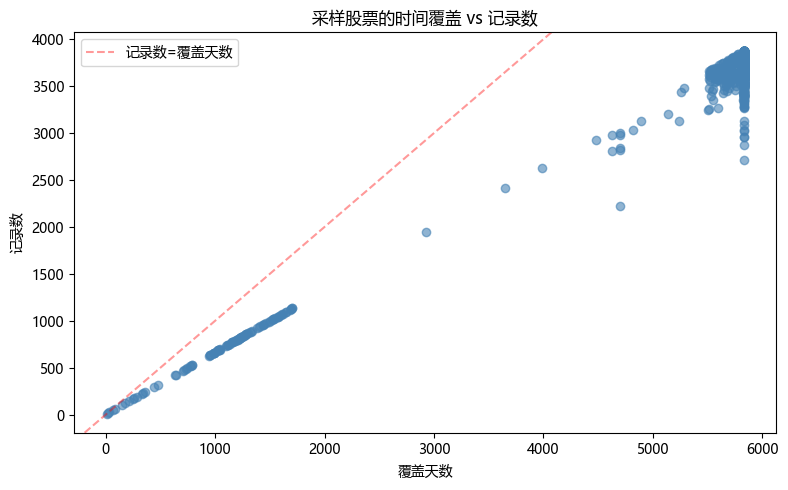

In [95]:
# 日线数据覆盖天数 vs 记录数散点
if not df_daily_stats.empty:
    df_daily_stats['开始日期'] = pd.to_datetime(df_daily_stats['开始日期'])
    df_daily_stats['结束日期'] = pd.to_datetime(df_daily_stats['结束日期'])
    df_daily_stats['覆盖天数'] = (df_daily_stats['结束日期'] - df_daily_stats['开始日期']).dt.days + 1
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.scatter(df_daily_stats['覆盖天数'], df_daily_stats['记录数'], alpha=0.6, color='steelblue')
    ax.set_xlabel('覆盖天数')
    ax.set_ylabel('记录数')
    ax.set_title('采样股票的时间覆盖 vs 记录数')
    ax.axline((0, 0), slope=1, color='red', linestyle='--', alpha=0.4, label='记录数=覆盖天数')
    ax.legend()
    plt.tight_layout()
    plt.show()

### 1.4 每日估值数据质量

检查估值数据: 100%|██████████| 1000/1000 [00:06<00:00, 143.65it/s]


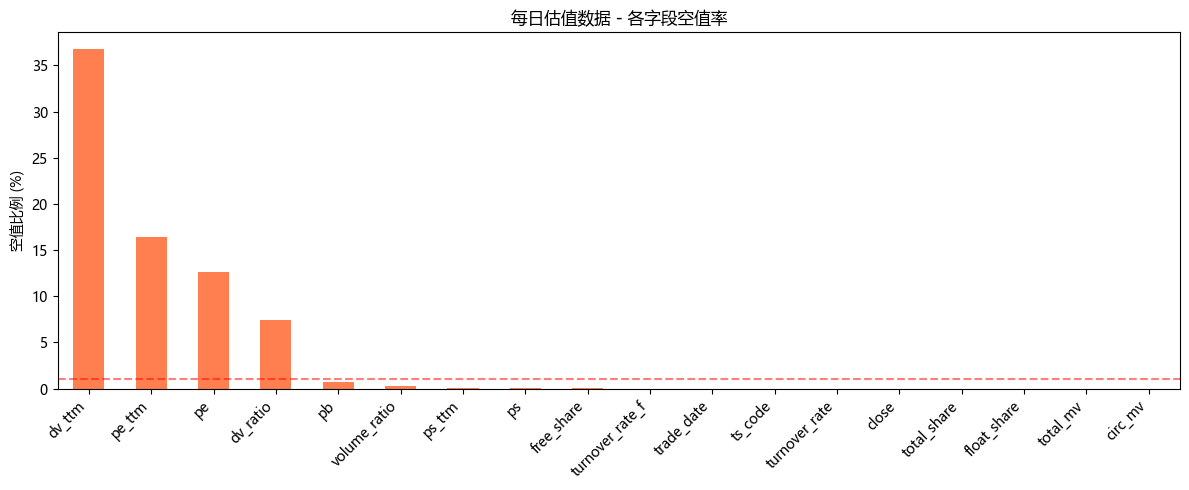


高空值字段 (>10%):
dv_ttm    36.753725
pe_ttm    16.403657
pe        12.622023
dtype: float64


In [96]:
# 采样检查估值数据
daily_basic_dir = raw_path / 'market' / 'daily_basic'
basic_files = list(daily_basic_dir.glob('*.parquet'))[:1000]

# 统计各字段的空值比例
null_rates = []
for f in tqdm(basic_files, desc='检查估值数据'):
    df = load_parquet(f)
    if len(df) > 0:
        null_rates.append(df.isnull().mean())

df_null = pd.DataFrame(null_rates).mean() * 100

# 可视化
fig, ax = plt.subplots(figsize=(12, 5))

df_null.sort_values(ascending=False).plot(kind='bar', ax=ax, color='coral')
ax.axhline(y=1, color='red', linestyle='--', alpha=0.5)

ax.set_ylabel('空值比例 (%)')
ax.set_title('每日估值数据 - 各字段空值率')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("\n高空值字段 (>10%):")
print(df_null[df_null > 10].sort_values(ascending=False))

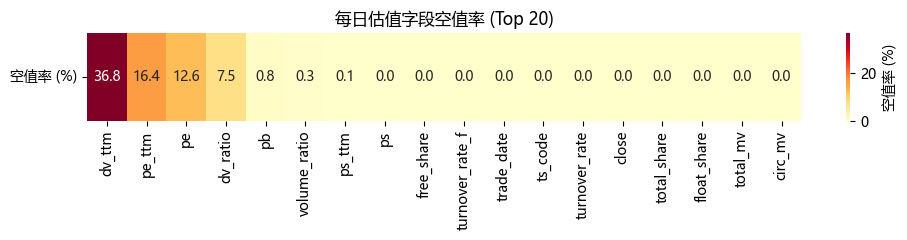

In [97]:
# 每日估值字段空值率热力图 (Top 20)
df_null_top = df_null.sort_values(ascending=False).head(20)
fig, ax = plt.subplots(figsize=(10, 2.5))
sns.heatmap(df_null_top.to_frame('空值率 (%)').T, cmap='YlOrRd', annot=True, fmt='.1f', cbar_kws={'label': '空值率 (%)'}, ax=ax)
ax.set_title('每日估值字段空值率 (Top 20)')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### 1.5 财务数据质量

In [98]:
# 采样检查财务指标
fina_dir = raw_path / 'fundamental' / 'fina_indicator'
fina_files = list(fina_dir.glob('*.parquet'))[:100]

# 统计关键财务指标的空值
key_cols = ['roe', 'roe_yearly', 'roa', 'grossprofit_margin', 
            'netprofit_margin', 'debt_to_assets', 'current_ratio']

fina_null_rates = []
for f in tqdm(fina_files, desc='检查财务指标'):
    df = load_parquet(f)
    if len(df) > 0:
        existing_cols = [c for c in key_cols if c in df.columns]
        fina_null_rates.append(df[existing_cols].isnull().mean())

df_fina_null = pd.DataFrame(fina_null_rates).mean() * 100

print("关键财务指标空值率:")
print(df_fina_null.sort_values(ascending=False).to_frame('空值率 (%)'))

检查财务指标: 100%|██████████| 100/100 [00:01<00:00, 90.34it/s]

关键财务指标空值率:
                    空值率 (%)
grossprofit_margin     2.17
roa                    2.00
current_ratio          1.74
roe_yearly             1.42
roe                    1.42
netprofit_margin       0.17
debt_to_assets         0.04


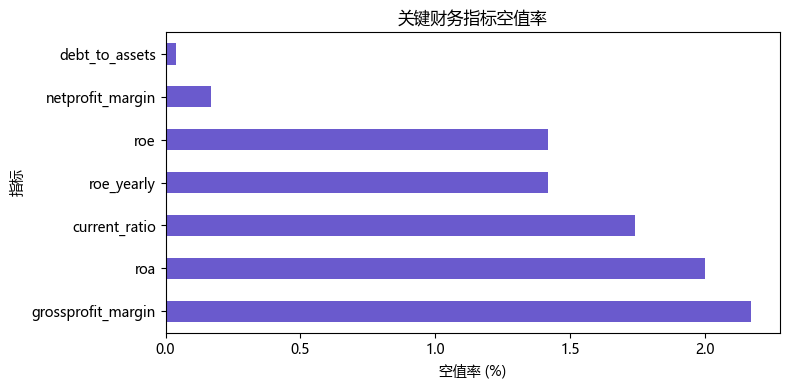

In [99]:
# 关键财务指标空值率条形图
df_fina_null_sorted = df_fina_null.sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(8, 4))
df_fina_null_sorted.plot(kind='barh', color='slateblue', ax=ax)
ax.set_xlabel('空值率 (%)')
ax.set_ylabel('指标')
ax.set_title('关键财务指标空值率')
plt.tight_layout()
plt.show()

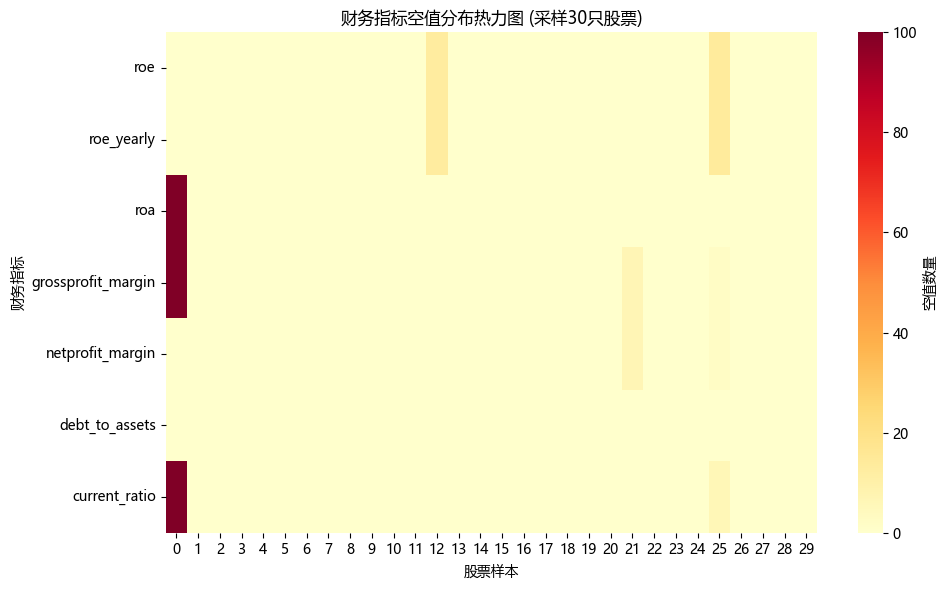

In [100]:
# 财务指标空值热力图
fig, ax = plt.subplots(figsize=(10, 6))

# 聚合所有采样数据
sample_data = []
for f in fina_files[:50]:
    df = load_parquet(f)
    existing_cols = [c for c in key_cols if c in df.columns]
    if len(existing_cols) > 0:
        sample_data.append(df[existing_cols].isnull().sum())

if sample_data:
    df_summary = pd.DataFrame(sample_data)
    
    # 空值分布热力图
    sns.heatmap(df_summary.T.iloc[:, :30], cmap='YlOrRd', ax=ax, cbar_kws={'label': '空值数量'})
    ax.set_xlabel('股票样本')
    ax.set_ylabel('财务指标')
    ax.set_title('财务指标空值分布热力图 (采样30只股票)')

plt.tight_layout()
plt.show()

### 1.6 异常值检测

In [101]:
# 加载一只典型股票进行异常值分析
daily_files_map = {f.stem: f for f in (daily_dir.glob('*.parquet'))}
basic_files_map = {f.stem: f for f in (daily_basic_dir.glob('*.parquet'))}

common_codes = sorted(set(daily_files_map) & set(basic_files_map))
if not common_codes:
    raise FileNotFoundError("日线与估值目录没有共同的股票文件可用于示例分析")

sample_code = common_codes[0]
sample_stock = load_parquet(daily_files_map[sample_code])
sample_basic = load_parquet(basic_files_map[sample_code])

# 合并数据
sample_merged = sample_stock.merge(sample_basic, on=['ts_code', 'trade_date'], how='left')

# 检测异常值 (基于 IQR)
def detect_outliers_iqr(series):
    """使用 IQR 检测异常值"""
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 3 * IQR
    upper = Q3 + 3 * IQR
    outliers = (series < lower) | (series > upper)
    return outliers.sum(), lower, upper

# 分析关键数值列
numeric_cols = ['close', 'vol', 'amount', 'pct_chg', 'pe_ttm', 'pb', 'turnover_rate']
outlier_stats = []

for col in numeric_cols:
    if col in sample_merged.columns:
        series = sample_merged[col].dropna()
        if len(series) > 0:
            n_outliers, lower, upper = detect_outliers_iqr(series)
            outlier_stats.append({
                '字段': col,
                '异常值数量': n_outliers,
                '异常值比例': f"{n_outliers / len(series) * 100:.2f}%",
                '正常范围': f"[{lower:.2f}, {upper:.2f}]"
            })

pd.DataFrame(outlier_stats)

,字段,异常值数量,异常值比例,正常范围
0,vol,48,1.26%,"[-1670454.80, 3271613.66]"
1,amount,53,1.39%,"[-2494850.48, 4601108.67]"
2,pct_chg,54,1.42%,"[-6.61, 6.50]"
3,pe_ttm,43,1.13%,"[-2.76, 18.30]"
4,pb,115,3.02%,"[-0.29, 2.30]"
5,turnover_rate,119,3.12%,"[-1.10, 2.41]"


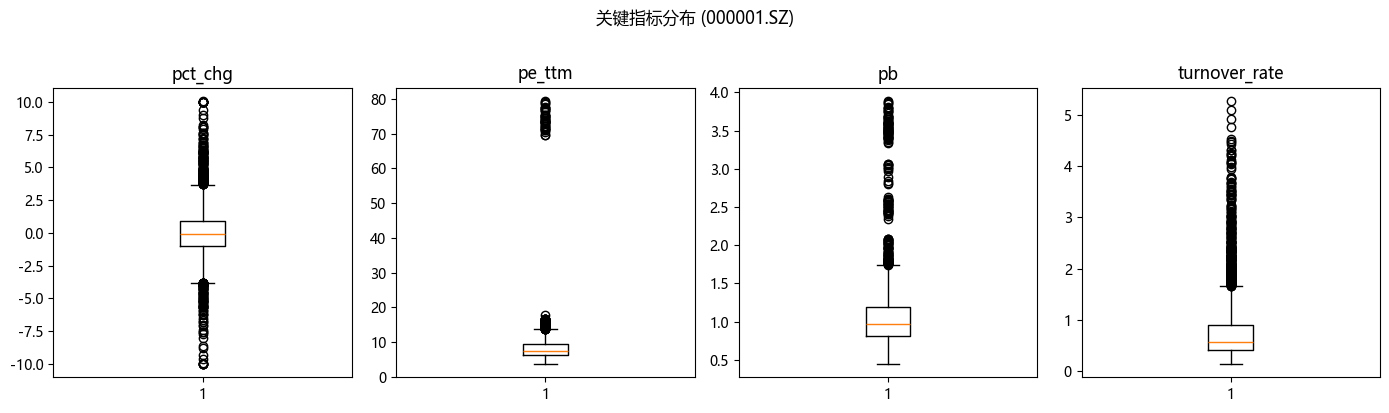

In [102]:
# 关键指标箱线图
fig, axes = plt.subplots(1, 4, figsize=(14, 4))

plot_cols = ['pct_chg', 'pe_ttm', 'pb', 'turnover_rate']

for ax, col in zip(axes, plot_cols):
    if col in sample_merged.columns:
        data = sample_merged[col].dropna()
        ax.boxplot(data, vert=True)
        ax.set_title(col)
        
plt.suptitle('关键指标分布 (000001.SZ)', y=1.02)
plt.tight_layout()
plt.show()

### 1.7 数据质量总结

In [103]:
# 加载已有的质量报告
import json

report_path = get_data_path('processed') / 'data_quality_report.json'
if report_path.exists():
    with open(report_path, 'r', encoding='utf-8') as f:
        quality_report = json.load(f)
    
    print("="*60)
    print("数据质量总体评估")
    print("="*60)
    
    for name, info in quality_report.items():
        status = info.get('状态', 'unknown')
        status_icon = '✓' if status == '通过' else '✗'
        count = (info.get('文件数量') or
                 info.get('股票数量') or
                 info.get('交易日数') or
                 info.get('记录数') or
                 info.get('采样记录数') or
                 'N/A')
        if '交易日数' in info:
            label = '交易日'
        elif '文件数量' in info or '股票数量' in info:
            label = '个文件/记录'
        else:
            label = '条记录'
        print(f"{status_icon} {name}: {count} {label}")

    print("\n" + "="*60)
    print("关键发现")
    print("="*60)
    print("""
1. 数据完整性: 8类核心数据全部覆盖 5,466 只股票
2. 时间范围: 2010年至2025年，约15年历史数据
3. 每日估值: pe_ttm 约 18% 空值，dv_ttm 约 42% 空值 (正常，部分股票不分红)
4. 财务数据: 空值较多是正常现象，不同行业指标不同
5. 建议关注: 使用 forward-fill 或行业均值填充关键估值空值
""")

数据质量总体评估
✓ 股票基础信息: 5466 个文件/记录
✓ 交易日历: 3883 交易日
✓ 日线行情: 5466 个文件/记录
✓ 每日估值: 5466 个文件/记录
✓ 财务指标: 5466 个文件/记录
✓ 利润表: 5466 个文件/记录
✓ 资产负债表: 5466 个文件/记录
✓ 现金流量表: 5466 个文件/记录

关键发现

1. 数据完整性: 8类核心数据全部覆盖 5,466 只股票
2. 时间范围: 2010年至2025年，约15年历史数据
3. 每日估值: pe_ttm 约 18% 空值，dv_ttm 约 42% 空值 (正常，部分股票不分红)
4. 财务数据: 空值较多是正常现象，不同行业指标不同
5. 建议关注: 使用 forward-fill 或行业均值填充关键估值空值



---

## ✅ 模块1 完成

**核心发现:**

| 数据类型 | 状态 | 说明 |
|----------|------|------|
| 日线行情 | ✓ 良好 | 5,466 只股票，空值率极低 |
| 每日估值 | ✓ 可用 | pe_ttm/dv_ttm 有空值，需关注 |
| 财务指标 | ✓ 可用 | 符合预期，行业差异导致空值 |

**下一步:** 进入模块2 - 日线行情分析